## 1) just plot the behavior

Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1\tail_panels_fish11_s10_baseline.pdf


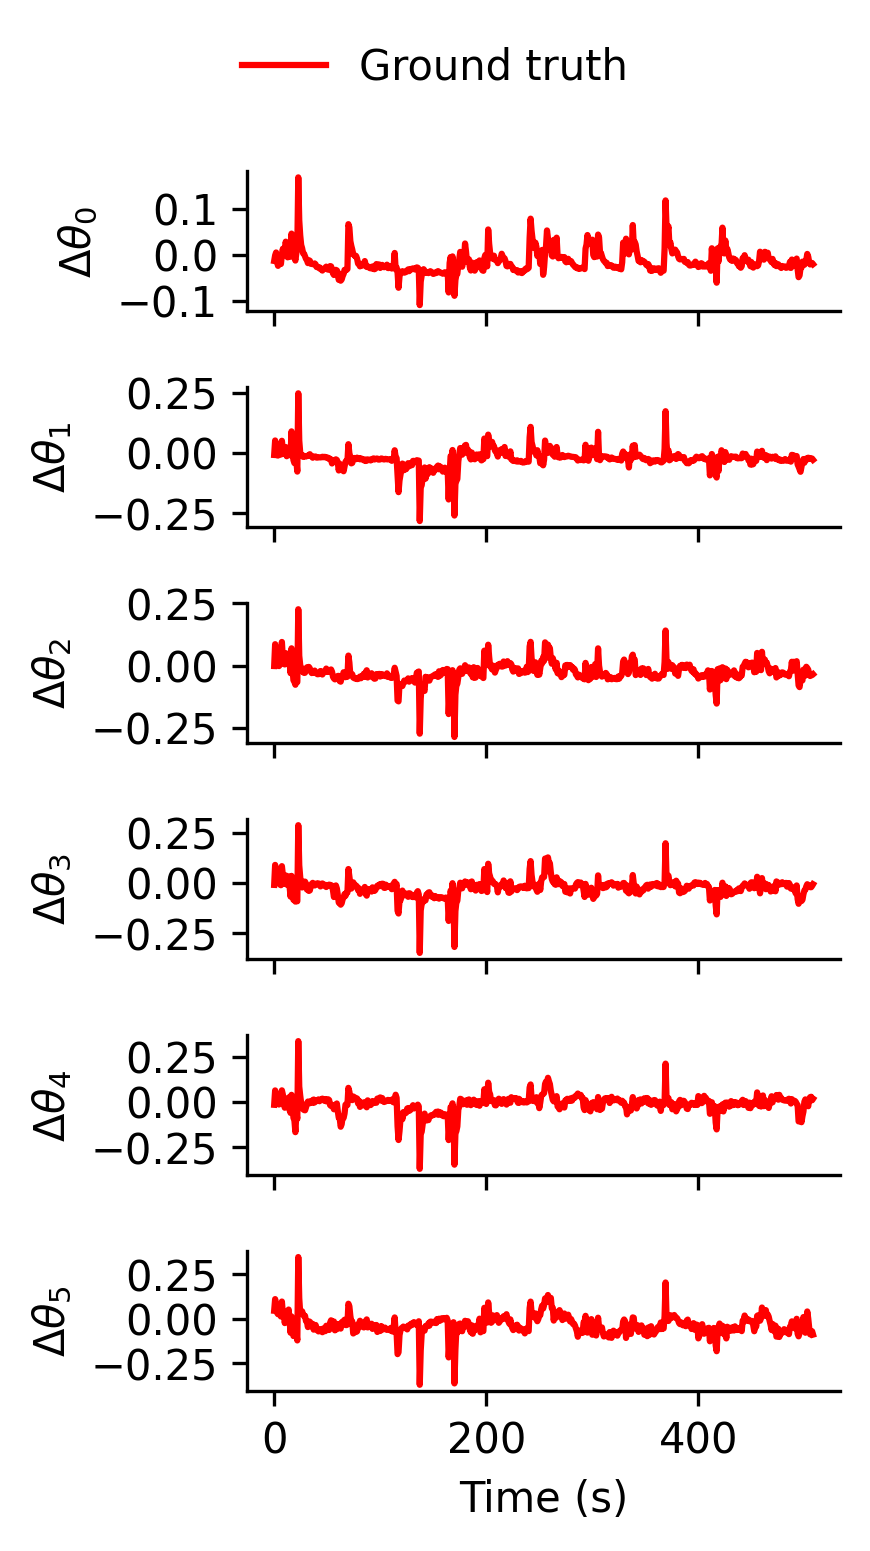

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# ─── CONFIG ───────────────────────────────────────────────────────────────────
fish             = 11
seq              = 10
use_components   = [0,1,2,3,4,5]
num_runs         = 10
models_to_use    = []
panel_plot       = True                       # True = per-theta panels; False = summed-tail

# Figure size control
width            = 3.0    # total figure width (inches)
height_per_panel = 0.8    # height per subplot (inches)

# Time‐frame selection: None for full, or (start,end)
frame_range      = None

# ─── I/O & MODEL MAPPING ───────────────────────────────────────────────────────
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir,
                 "external_data","nlp4neuro","results_april30","experiment_1")
)
full_model_map = {
    "GPT-2 (base)"      : ("gpt2_pretrained", "#1f77b4"),
    "LSTM"              : ("lstm",            "#ff7f0e"),
    "DeepSeek-coder-7b" : ("deepseek_moe",    "#000000"),
    "BERT-small"        : ("bert",            "#7f7f7f"),
}
model_map = {m: full_model_map[m] for m in models_to_use}

# ─── LOAD & SLICE GROUND TRUTH ────────────────────────────────────────────────
gt_path  = os.path.join(
    RESULTS_ROOT, f"fish{fish}",
    f"fish{fish}_final_predictions_groundtruth_test.npy"
)
y_true   = np.load(gt_path)                    # shape (T,6)
time_vec = np.arange(y_true.shape[0]) / 1.1    # 1.1 Hz sampling

if frame_range is not None:
    start, end = frame_range
    y_true     = y_true[start:end]
    time_vec   = time_vec[start:end]

plt.rcParams["pdf.fonttype"] = 42

if panel_plot:
    # ─── PANEL VIEW ─────────────────────────────────────────────────────────
    # compute baseline per component from first 50 frames
    baselines = {comp: np.mean(y_true[:50, comp]) for comp in use_components}

    n = len(use_components)
    fig, axes = plt.subplots(
        n, 1, sharex=True,
        figsize=(width, height_per_panel * n),
        dpi=300
    )

    for idx, comp in enumerate(use_components):
        ax = axes[idx]
        # ground truth (shifted by baseline)
        gt_label = "Ground truth" if idx == 0 else None
        y_gt     = y_true[:, comp] - baselines[comp]
        ax.plot(time_vec, y_gt,
                color="red", lw=1.5, label=gt_label)

        # each model
        for model_name, (key, color) in model_map.items():
            runs = []
            for run in range(1, num_runs + 1):
                fpath = os.path.join(
                    RESULTS_ROOT,
                    f"fish{fish}", f"run_{run}",
                    f"seq_{seq}",
                    f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
                )
                if not os.path.isfile(fpath):
                    continue
                pred = np.load(fpath)
                if frame_range is not None:
                    pred = pred[start:end]
                runs.append(pred[:, comp] - baselines[comp])

            if not runs:
                continue

            data    = np.vstack(runs)
            mean_ts = data.mean(axis=0)
            sem_ts  = sem(data, axis=0)
            mlabel  = model_name if idx == 0 else None

            ax.plot(time_vec, mean_ts,
                    color=color, lw=1.2, label=mlabel)
            ax.fill_between(time_vec,
                            mean_ts - sem_ts,
                            mean_ts + sem_ts,
                            color=color, alpha=0.2)

        ax.set_ylabel(rf"$\Delta\theta_{{{comp}}}$")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # single-row legend above panels
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        ncol=len(handles),
        frameon=False,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.0),
        bbox_transform=fig.transFigure
    )
    fig.subplots_adjust(top=0.85)
    axes[-1].set_xlabel("Time (s)")
    fig.tight_layout()
    out_name = f"tail_panels_fish{fish}_s{seq}_baseline.pdf"

else:
    # ─── SUMMED-TAIL VIEW ─────────────────────────────────────────────────────
    # baseline from ground truth sum
    y_sum_full    = y_true[:, use_components].sum(axis=1)
    baseline_sum  = np.mean(y_sum_full[:50])
    y_sum_shifted = y_sum_full - baseline_sum

    fig, ax = plt.subplots(figsize=(width, height_per_panel), dpi=300)

    ax.plot(time_vec, y_sum_shifted,
            color="red", lw=1.5, label="Ground truth")

    for model_name, (key, color) in model_map.items():
        runs = []
        for run in range(1, num_runs + 1):
            fpath = os.path.join(
                RESULTS_ROOT,
                f"fish{fish}", f"run_{run}",
                f"seq_{seq}",
                f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
            )
            if not os.path.isfile(fpath):
                continue
            pred = np.load(fpath)
            if frame_range is not None:
                pred = pred[start:end]
            runs.append(pred[:, use_components].sum(axis=1) - baseline_sum)

        if not runs:
            continue

        data    = np.vstack(runs)
        mean_ts = data.mean(axis=0)
        sem_ts  = sem(data, axis=0)

        ax.plot(time_vec, mean_ts,
                color=color, lw=1.2, label=model_name)
        ax.fill_between(time_vec,
                        mean_ts - sem_ts,
                        mean_ts + sem_ts,
                        color=color, alpha=0.2)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta \sum_{i}\theta_i$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(ncol=1, frameon=False, loc="upper right")
    fig.tight_layout()
    out_name = f"tail_sum_fish{fish}_s{seq}_baseline.pdf"

# ─── SAVE ─────────────────────────────────────────────────────────────────────
out_file = os.path.join(RESULTS_ROOT, out_name)
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print("Saved to", out_file)


## 2) models vs behavior plots

Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1\tail_panels_fish11_s10_baseline.pdf


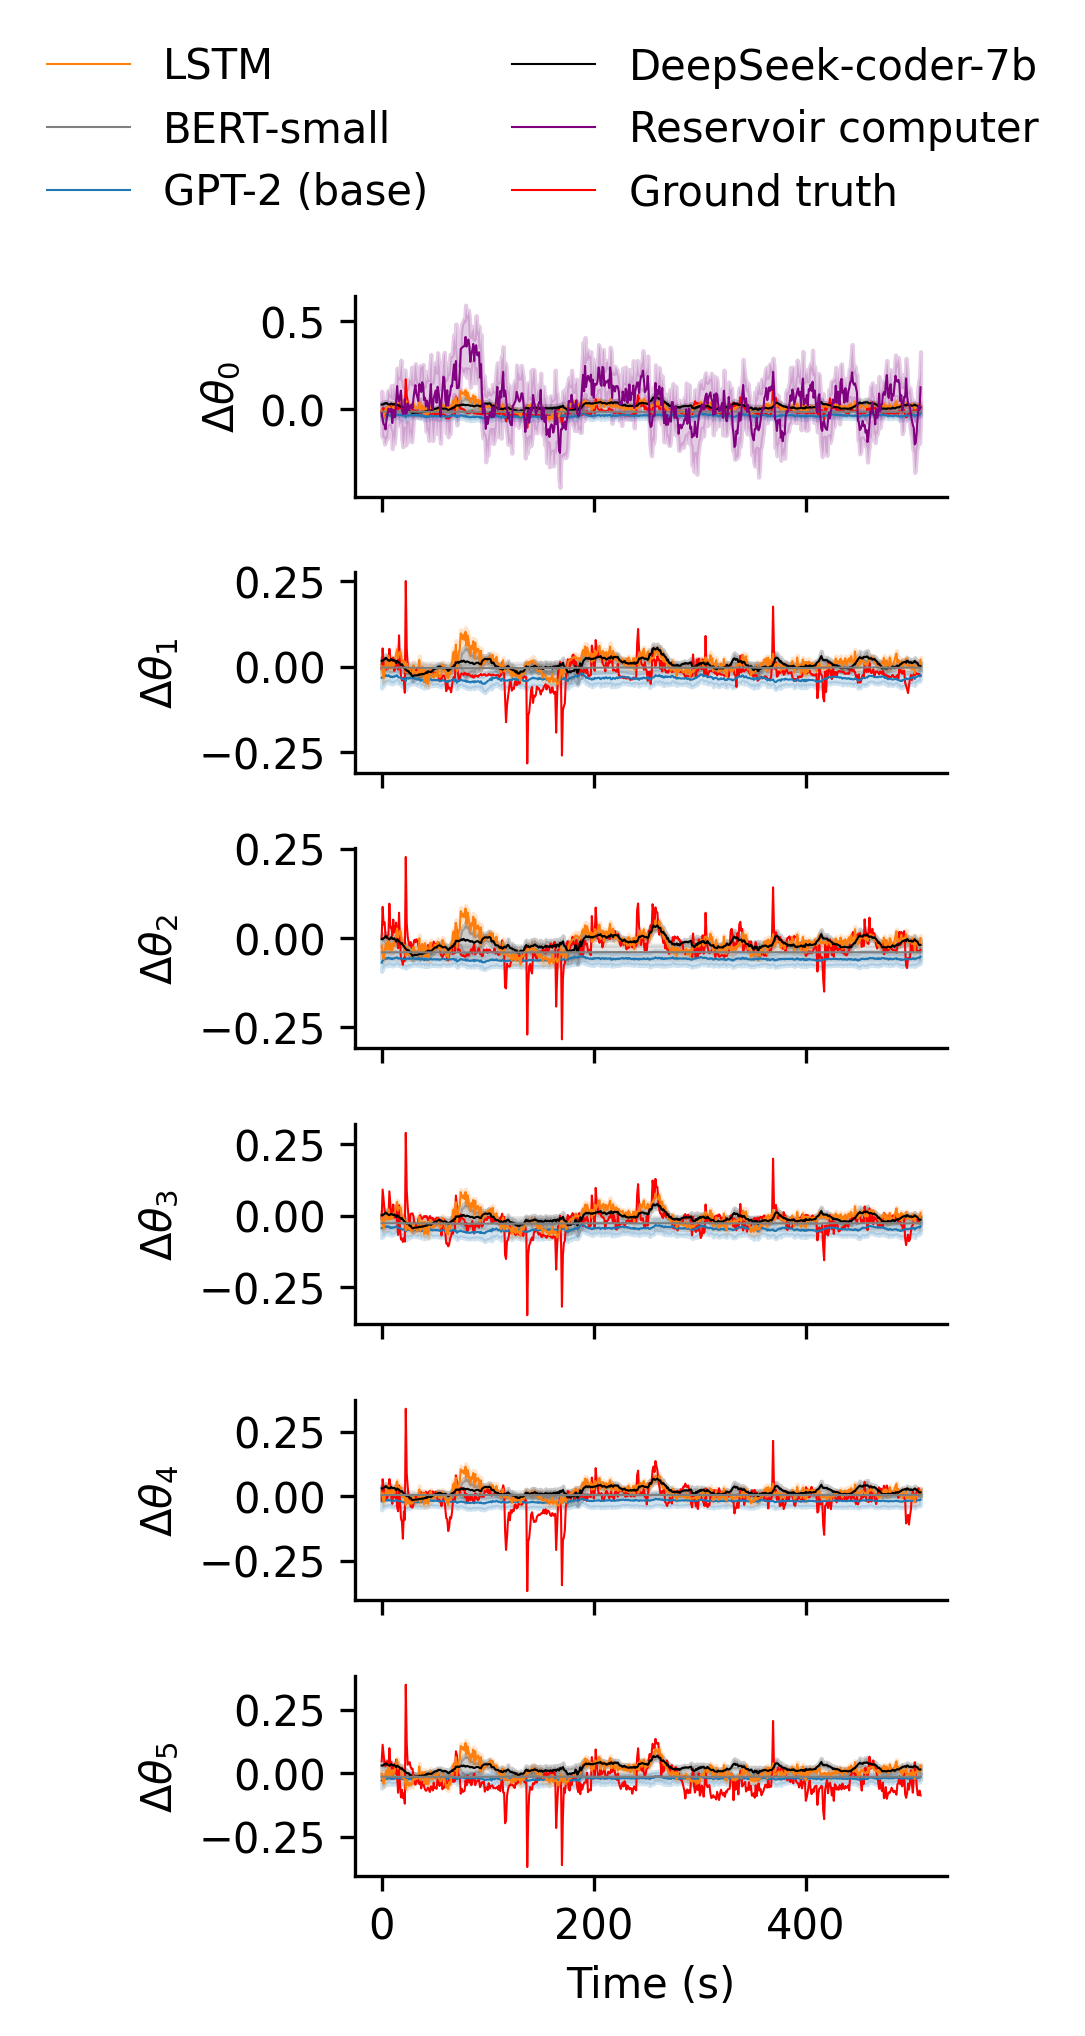

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from matplotlib.lines import Line2D

# ─── CONFIG ───────────────────────────────────────────────────────────────────
fish                   = 11
seq                    = 10
use_components         = [0,1,2,3,4,5]
num_runs               = 10
models_to_use          = ["GPT-2 (base)", "LSTM", "DeepSeek-coder-7b", "BERT-small", "Reservoir computer"]
panel_plot             = True   # True = per-theta panels; False = summed-tail

# Plot RC only in first panel, and control legend style
reservoir_in_legend    = True  # ← toggle this to get a single 2×3 legend (all 5 models + GT)

# Optional: plot a single run instead of the mean ± CI
single_run             = None   # set to 1..num_runs or None

# Figure size & sampling
width                  = 3      # inches
height_per_panel       = 1      # inches per subplot
frame_range            = None   # e.g. (start, end) or None
sampling_rate_hz       = 1.1

# ─── I/O & MODEL MAPPING ───────────────────────────────────────────────────────
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir,
                 "external_data","nlp4neuro","results_april30","experiment_1")
)
full_model_map = {
    "GPT-2 (base)"      : ("gpt2_pretrained", "#1f77b4"),
    "LSTM"              : ("lstm",            "#ff7f0e"),
    "DeepSeek-coder-7b" : ("deepseek_moe",    "#000000"),
    "BERT-small"        : ("bert",            "#7f7f7f"),
    "Reservoir computer"                : ("reservoir",       "purple"),
}
model_map = {m: full_model_map[m] for m in models_to_use}

# ─── LOAD GROUND TRUTH ─────────────────────────────────────────────────────────
gt_path  = os.path.join(
    RESULTS_ROOT, f"fish{fish}", 
    f"fish{fish}_final_predictions_groundtruth_test.npy"
)
y_true   = np.load(gt_path)                         # shape (T,6)
time_vec = np.arange(y_true.shape[0]) / sampling_rate_hz

if frame_range is not None:
    start, end = frame_range
    y_true      = y_true[start:end]
    time_vec    = time_vec[start:end]

plt.rcParams["pdf.fonttype"] = 42

# ─── RUN SELECTION HELPER ─────────────────────────────────────────────────────
def get_run_list():
    return [single_run] if single_run is not None else range(1, num_runs + 1)

# ─── PANEL PLOT ───────────────────────────────────────────────────────────────
if panel_plot:
    baselines = {c: np.mean(y_true[:50, c]) for c in use_components}
    n = len(use_components)
    fig, axes = plt.subplots(n, 1, sharex=True,
                             figsize=(width, height_per_panel * n),
                             dpi=300)

    for idx, comp in enumerate(use_components):
        ax = axes[idx]

        # ── Ground truth
        gt_label = "Ground truth" if idx == 0 else None
        y_gt      = y_true[:, comp] - baselines[comp]
        ax.plot(time_vec, y_gt,
                color="red", lw=0.5, label=gt_label)

        # ── Models (but RC only on first panel)
        for model_name, (key, color) in model_map.items():
            if model_name == "Reservoir computer" and idx != 0:
                continue

            runs = []
            for run in get_run_list():
                fpath = os.path.join(
                    RESULTS_ROOT,
                    f"fish{fish}", f"run_{run}",
                    f"seq_{seq}",
                    f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
                )
                if not os.path.isfile(fpath):
                    continue
                pred = np.load(fpath)
                if frame_range is not None:
                    pred = pred[start:end]
                runs.append(pred[:, comp] - baselines[comp])

            if not runs:
                continue

            data    = np.vstack(runs)
            mean_ts = data.mean(axis=0)
            sem_ts  = sem(data, axis=0)
            df      = data.shape[0] - 1
            ci_mult = t.ppf(0.975, df=df) if df > 0 else 0
            ci      = ci_mult * sem_ts

            mlabel = model_name if idx == 0 else None
            ax.plot(time_vec, mean_ts,
                    color=color, lw=0.5, label=mlabel)
            ax.fill_between(time_vec,
                            mean_ts - ci,
                            mean_ts + ci,
                            color=color, alpha=0.2)

        ax.set_ylabel(rf"$\Delta\theta_{{{comp}}}$")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # ─── LEGEND(S) ────────────────────────────────────────────────────────────
    handles, labels = axes[0].get_legend_handles_labels()
    hdict           = dict(zip(labels, handles))

    if reservoir_in_legend:
        # single 2×3 legend: 5 models + ground truth
        ordered = [
            "LSTM",
            "BERT-small",
            "GPT-2 (base)",
            "DeepSeek-coder-7b",
            "Reservoir computer",
            "Ground truth"
        ]
        leg_h = [hdict[l] for l in ordered]
        fig.legend(
            leg_h, ordered,
            ncol=2,
            frameon=False,
            loc="lower center",
            bbox_to_anchor=(0.5, 1.00),
            bbox_transform=fig.transFigure
        )
        fig.subplots_adjust(top=0.85)

    else:
        # fallback: two legends
        # 1) 2×2 of the four non-RC models
        model_order   = ["LSTM", "BERT-small", "GPT-2 (base)", "DeepSeek-coder-7b"]
        model_handles = [hdict[m] for m in model_order]
        fig.legend(
            model_handles, model_order,
            ncol=2,
            frameon=False,
            loc="lower center",
            bbox_to_anchor=(0.5, 1.00),
            bbox_transform=fig.transFigure
        )

        # 2) Ground truth below
        gt_hdl = hdict["Ground truth"]
        fig.legend(
            [gt_hdl], ["Ground truth"],
            ncol=1,
            frameon=False,
            loc="lower center",
            bbox_to_anchor=(0.5, 0.95),
            bbox_transform=fig.transFigure
        )
        fig.subplots_adjust(top=0.85)

    axes[-1].set_xlabel("Time (s)")
    fig.tight_layout()
    out_name = f"tail_panels_fish{fish}_s{seq}_baseline.pdf"

# ─── SUMMED-TAIL PLOT ─────────────────────────────────────────────────────────
else:
    y_sum_full    = y_true[:, use_components].sum(axis=1)
    baseline_sum  = np.mean(y_sum_full[:50])
    y_sum_shifted = y_sum_full - baseline_sum

    fig, ax = plt.subplots(figsize=(width, height_per_panel), dpi=300)
    ax.plot(time_vec, y_sum_shifted,
            color="red", lw=1.0, label="Ground truth")

    for model_name, (key, color) in model_map.items():
        runs = []
        for run in get_run_list():
            fpath = os.path.join(
                RESULTS_ROOT,
                f"fish{fish}", f"run_{run}",
                f"seq_{seq}",
                f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
            )
            if not os.path.isfile(fpath):
                continue
            pred = np.load(fpath)
            if frame_range is not None:
                pred = pred[start:end]
            runs.append(pred[:, use_components].sum(axis=1) - baseline_sum)

        if not runs:
            continue

        data    = np.vstack(runs)
        mean_ts = data.mean(axis=0)
        sem_ts  = sem(data, axis=0)
        df      = data.shape[0] - 1
        ci_mult = t.ppf(0.975, df=df) if df > 0 else 0
        ci      = ci_mult * sem_ts

        ax.plot(time_vec, mean_ts,
                color=color, lw=0.8, label=model_name)
        ax.fill_between(time_vec,
                        mean_ts - ci,
                        mean_ts + ci,
                        color=color, alpha=0.2)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta \sum_{i}\theta_i$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(ncol=2, frameon=False, loc="upper right")

    fig.tight_layout()
    out_name = f"tail_sum_fish{fish}_s{seq}_baseline.pdf"

# ─── SAVE ─────────────────────────────────────────────────────────────────────
out_file = os.path.join(RESULTS_ROOT, out_name)
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print("Saved to", out_file)


## Add event times

Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1\tail_panels_fish11_s10_baseline.pdf


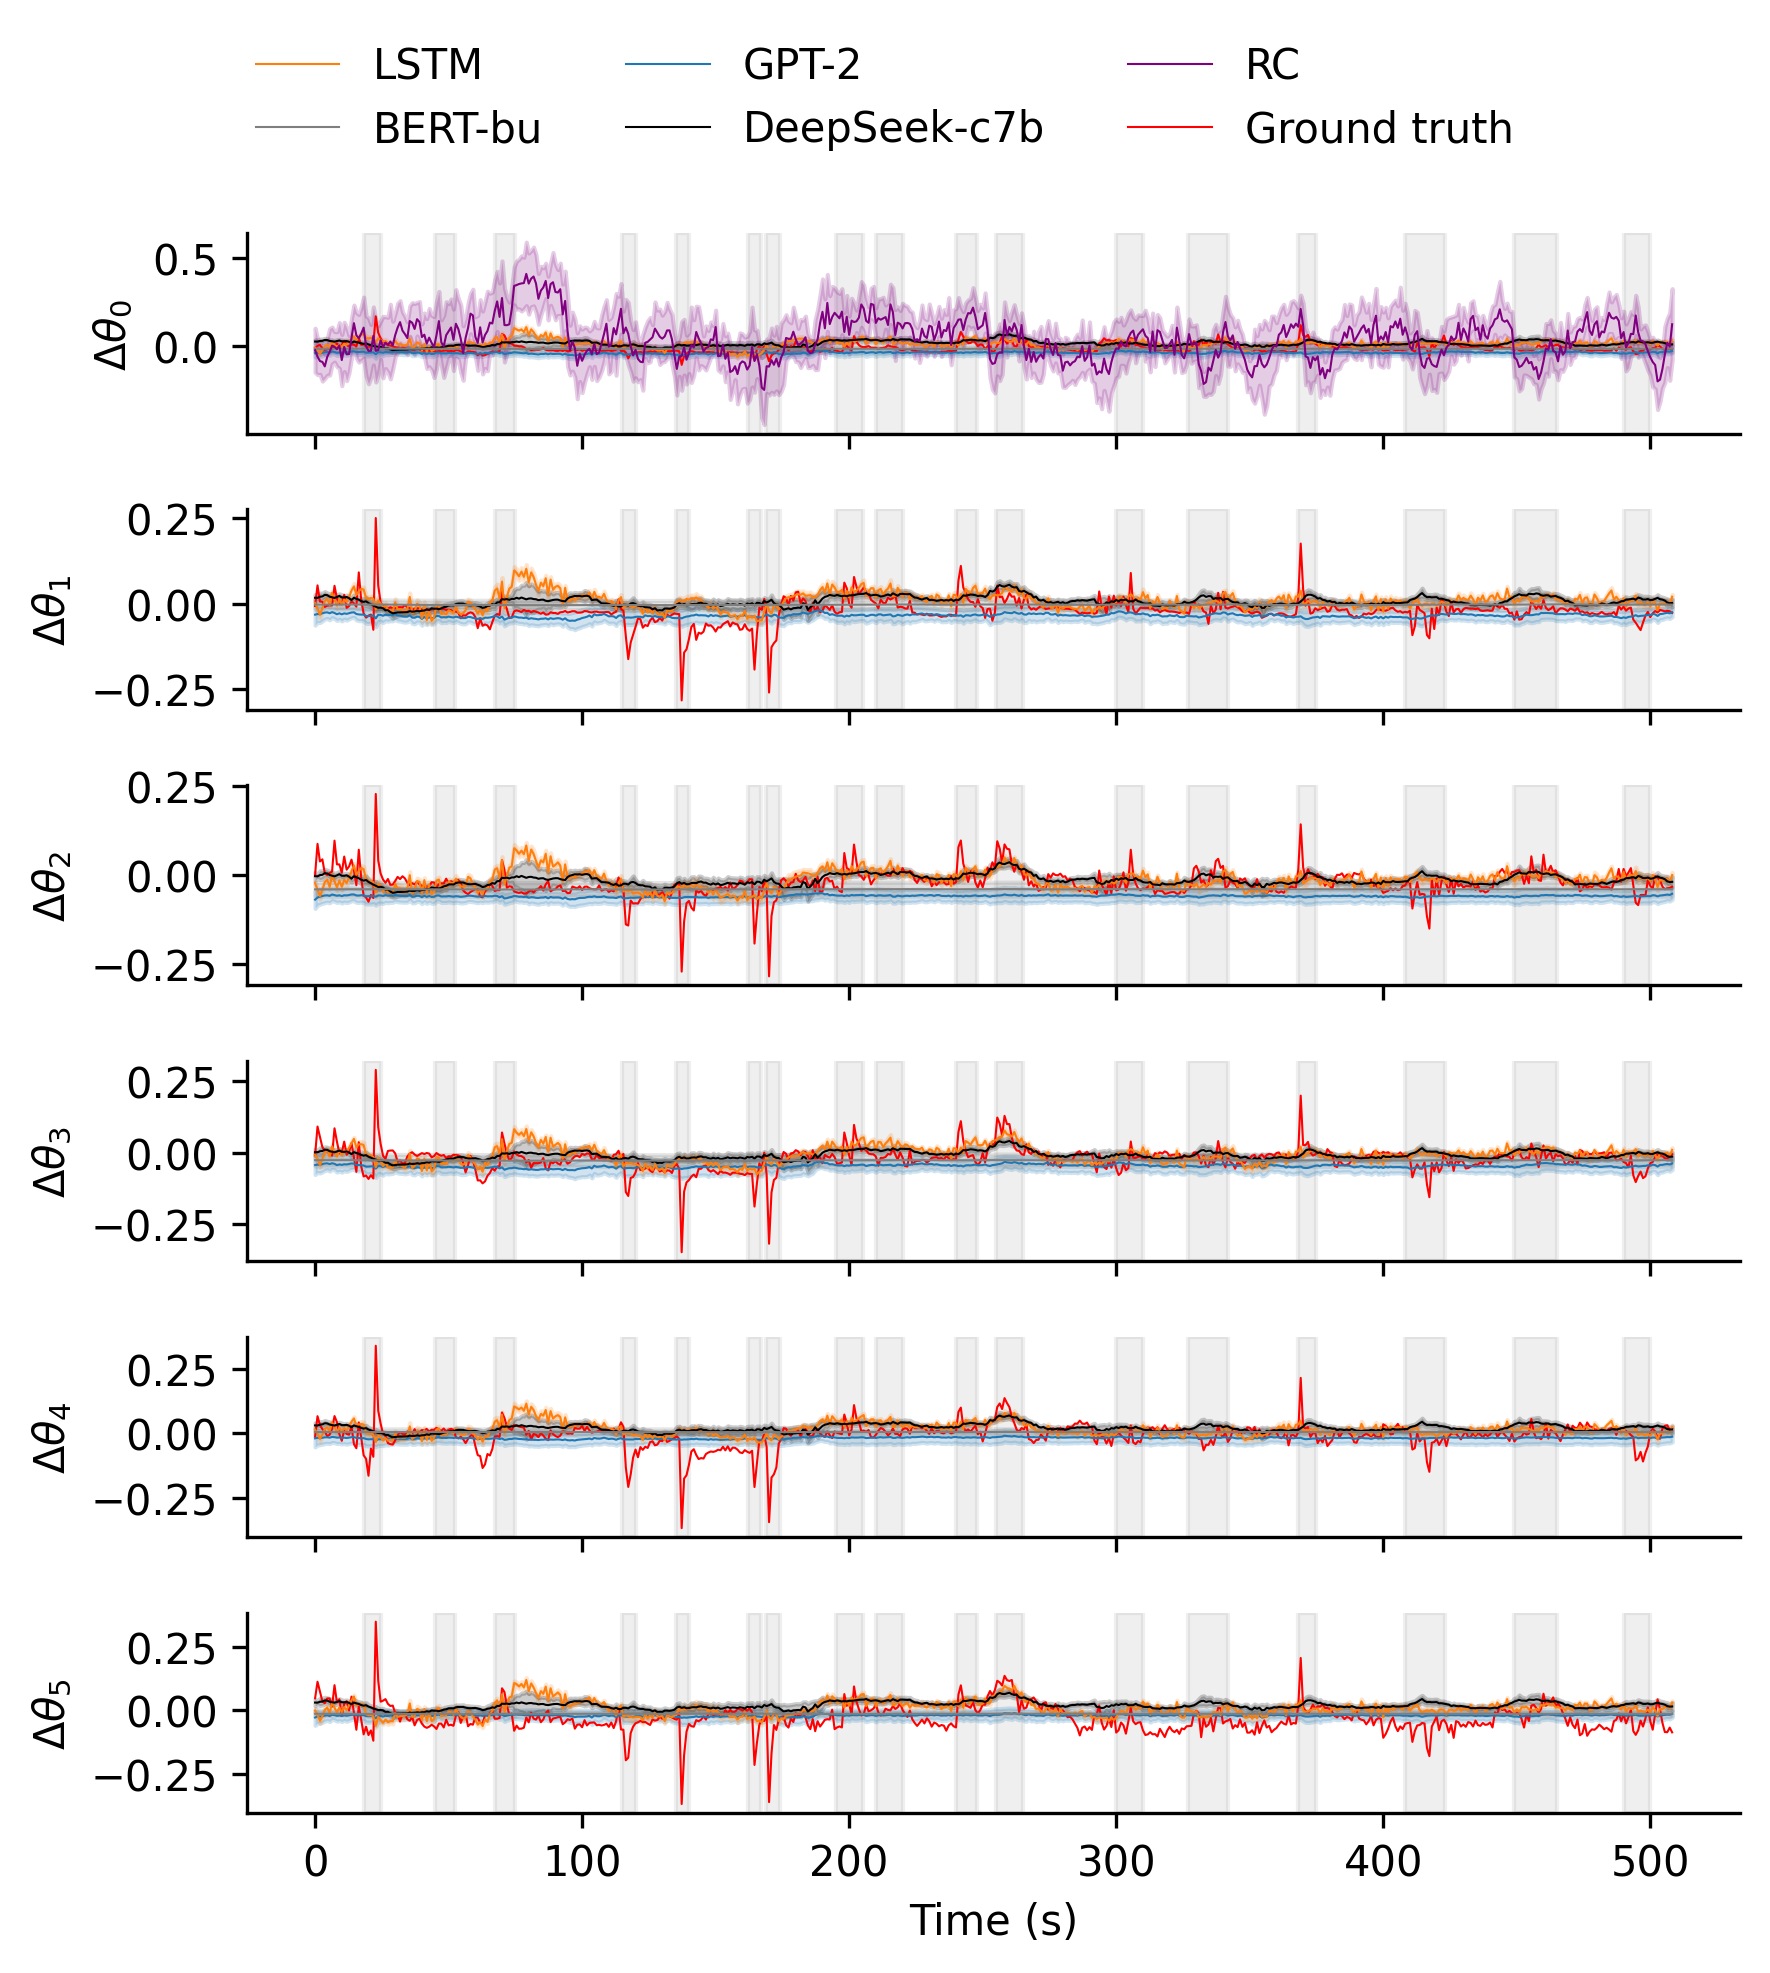

In [8]:
#!/usr/bin/env python3
"""
Plot ground-truth tail angles vs. model predictions, with optional event shading.

Edit the EVENTS list below to control where transparent grey rectangles
are drawn across every subplot. Increase width to make the plot wider
so your legend never overhangs.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from matplotlib.lines import Line2D

# ─── CONFIG ───────────────────────────────────────────────────────────────────
fish                   = 11
seq                    = 10
use_components         = [0, 1, 2, 3, 4, 5]
num_runs               = 10
# updated model names here:
models_to_use          = [
    "GPT-2",
    "LSTM",
    "DeepSeek-c7b",
    "BERT-bu",
    "RC",
]
panel_plot             = True    # True = per-component panels; False = summed-tail
reservoir_in_legend    = True    # put RC in the same single legend
single_run             = None    # set to 1..num_runs to plot just one run
width                  = 6       # inches — increase this to give more room
height_per_panel       = 1       # inches per subplot
frame_range            = None    # e.g. (start_idx, end_idx) or None
sampling_rate_hz       = 1.1     # frames per second

# ─── EVENT SHADING (edit these!) ──────────────────────────────────────────────
EVENTS = [
    (18.3,  24.7), (45.0,  52.5), (67.2, 75.0),
    (115, 120), (135, 140), (162, 167),
    (169, 174), (195, 205), (210, 220),
    (240, 248), (255, 265), (300, 310),
    (327, 342), (368, 375), (408, 423),
    (449, 465), (490, 500)
]
EVENT_COLOR = "gray"
EVENT_ALPHA = 0.12

# ─── I/O & MODEL MAPPING ───────────────────────────────────────────────────────
RESULTS_ROOT = os.path.abspath(
    os.path.join(
        os.getcwd(),
        os.pardir, os.pardir, os.pardir,
        "external_data", "nlp4neuro", "results_april30", "experiment_1"
    )
)
full_model_map = {
    "GPT-2"       : ("gpt2_pretrained", "#1f77b4"),
    "LSTM"        : ("lstm",            "#ff7f0e"),
    "DeepSeek-c7b": ("deepseek_moe",    "#000000"),
    "BERT-bu"     : ("bert",            "#7f7f7f"),
    "RC"          : ("reservoir",       "purple"),
}
model_map = {m: full_model_map[m] for m in models_to_use}

# ─── LOAD GROUND TRUTH ─────────────────────────────────────────────────────────
gt_path  = os.path.join(
    RESULTS_ROOT,
    f"fish{fish}",
    f"fish{fish}_final_predictions_groundtruth_test.npy"
)
y_true   = np.load(gt_path)                       # shape (T, n_components)
time_vec = np.arange(y_true.shape[0]) / sampling_rate_hz

if frame_range is not None:
    start, end = frame_range
    y_true      = y_true[start:end]
    time_vec    = time_vec[start:end]

plt.rcParams["pdf.fonttype"] = 42

# ─── RUN SELECTION HELPER ─────────────────────────────────────────────────────
def get_run_list():
    return [single_run] if single_run is not None else range(1, num_runs + 1)

# ─── PANEL PLOT ───────────────────────────────────────────────────────────────
if panel_plot:
    baselines = {c: np.mean(y_true[:50, c]) for c in use_components}
    n_panels  = len(use_components)
    fig, axes = plt.subplots(
        n_panels, 1,
        sharex=True,
        figsize=(width, height_per_panel * n_panels),
        dpi=300
    )

    for idx, comp in enumerate(use_components):
        ax = axes[idx]

        # Event shading
        for start_s, end_s in EVENTS:
            ax.axvspan(start_s, end_s, color=EVENT_COLOR, alpha=EVENT_ALPHA, zorder=0)

        # Ground truth
        gt_label = "Ground truth" if idx == 0 else None
        y_gt     = y_true[:, comp] - baselines[comp]
        ax.plot(time_vec, y_gt, color="red", lw=0.5, label=gt_label)

        # Model traces (RC only in first panel)
        for model_name, (key, color) in model_map.items():
            if model_name == "RC" and idx != 0:
                continue

            runs = []
            for run in get_run_list():
                fpath = os.path.join(
                    RESULTS_ROOT,
                    f"fish{fish}", f"run_{run}",
                    f"seq_{seq}",
                    f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
                )
                if not os.path.isfile(fpath):
                    continue
                pred = np.load(fpath)
                if frame_range is not None:
                    pred = pred[start:end]
                runs.append(pred[:, comp] - baselines[comp])

            if not runs:
                continue

            data    = np.vstack(runs)
            mean_ts = data.mean(axis=0)
            sem_ts  = sem(data, axis=0)
            df      = data.shape[0] - 1
            ci_mult = t.ppf(0.975, df=df) if df > 0 else 0
            ci      = ci_mult * sem_ts

            mlabel = model_name if idx == 0 else None
            ax.plot(time_vec, mean_ts, color=color, lw=0.5, label=mlabel)
            ax.fill_between(time_vec,
                            mean_ts - ci,
                            mean_ts + ci,
                            color=color, alpha=0.2)

        ax.set_ylabel(rf"$\Delta\theta_{{{comp}}}$")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # GLOBAL LEGEND with 3 columns → 2 rows of 3
    handles, labels = axes[0].get_legend_handles_labels()
    hdict           = dict(zip(labels, handles))

    if reservoir_in_legend:
        ordered = [
            "LSTM",
            "BERT-bu",
            "GPT-2",
            "DeepSeek-c7b",
            "RC",
            "Ground truth"
        ]
        leg_h = [hdict[l] for l in ordered]
        fig.legend(
            leg_h, ordered,
            ncol=3, frameon=False,       # ← now 3 columns
            loc="lower center",
            bbox_to_anchor=(0.5, 1.00),
            bbox_transform=fig.transFigure
        )
        fig.subplots_adjust(top=0.85)
    else:
        # fallback two-legend layout
        model_order   = ["LSTM", "BERT-bu", "GPT-2", "DeepSeek-c7b", "RC"]
        model_handles = [hdict[m] for m in model_order]
        fig.legend(
            model_handles, model_order,
            ncol=3, frameon=False,     # ← 3 columns here too
            loc="lower center",
            bbox_to_anchor=(0.5, 1.00),
            bbox_transform=fig.transFigure
        )
        gt_hdl = hdict["Ground truth"]
        fig.legend(
            [gt_hdl], ["Ground truth"],
            ncol=1, frameon=False,
            loc="lower center",
            bbox_to_anchor=(0.5, 0.95),
            bbox_transform=fig.transFigure
        )
        fig.subplots_adjust(top=0.85)

    axes[-1].set_xlabel("Time (s)")
    fig.tight_layout()
    out_name = f"tail_panels_fish{fish}_s{seq}_baseline.pdf"

# ─── SUMMED-TAIL PLOT ─────────────────────────────────────────────────────────
else:
    y_sum_full    = y_true[:, use_components].sum(axis=1)
    baseline_sum  = np.mean(y_sum_full[:50])
    y_sum_shifted = y_sum_full - baseline_sum

    fig, ax = plt.subplots(figsize=(width, height_per_panel), dpi=300)

    # Event shading
    for start_s, end_s in EVENTS:
        ax.axvspan(start_s, end_s, color=EVENT_COLOR, alpha=EVENT_ALPHA, zorder=0)

    ax.plot(time_vec, y_sum_shifted, color="red", lw=1.0, label="Ground truth")

    for model_name, (key, color) in model_map.items():
        runs = []
        for run in get_run_list():
            fpath = os.path.join(
                RESULTS_ROOT,
                f"fish{fish}", f"run_{run}",
                f"seq_{seq}",
                f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
            )
            if not os.path.isfile(fpath):
                continue
            pred = np.load(fpath)
            if frame_range is not None:
                pred = pred[start:end]
            runs.append(pred[:, use_components].sum(axis=1) - baseline_sum)

        if not runs:
            continue

        data    = np.vstack(runs)
        mean_ts = data.mean(axis=0)
        sem_ts  = sem(data, axis=0)
        df      = data.shape[0] - 1
        ci_mult = t.ppf(0.975, df=df) if df > 0 else 0
        ci      = ci_mult * sem_ts

        ax.plot(time_vec, mean_ts, color=color, lw=0.8, label=model_name)
        ax.fill_between(time_vec,
                        mean_ts - ci,
                        mean_ts + ci,
                        color=color, alpha=0.2)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta \sum_{i}\theta_i$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(ncol=3, frameon=False, loc="upper right")  # ← 3 columns here too

    fig.tight_layout()
    out_name = f"tail_sum_fish{fish}_s{seq}_baseline2.pdf"

# ─── SAVE TO FILE ─────────────────────────────────────────────────────────────
out_file = os.path.join(RESULTS_ROOT, out_name)
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print("Saved to", out_file)
